# Procedural

Mount my drive and create a folder for the data if it doesn't already exist

In [1]:
CUDA_LAUNCH_BLOCKING="1"

In [2]:
# Mount my drive
from google.colab import drive
drive.mount('/content/drive')

# Create a folder for the data if it does not already exist
import os
if not os.path.exists('/content/drive/MyDrive/MastersProject/data/'):
    os.makedirs('/content/drive/MyDrive/MastersProject/data/')
    print("Created the folder!")
else:
    print("Folder already existed!")

Mounted at /content/drive
Folder already existed!


In [3]:
!pip install psutil

In [4]:
!pip install transformers

     |████████████████████████████████| 2.5MB 13.9MB/s 
     |████████████████████████████████| 901kB 59.4MB/s 
     |████████████████████████████████| 3.3MB 49.8MB/s 


In [5]:
import time
import pandas as pd
import torch
import numpy as np
from torch import nn, optim, utils
import psutil
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import random
import transformers

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
RANDOM_SEED = 42

# Prepare the data for training

Set the hyperparameters needed for data preparation

In [ ]:
BATCH_SIZE = 16
DATA_TO_FETCH = "title_full"      # in {text_pooled, title_pooled, title_full}
REBALANCE_METHOD = "reweighing"     # in {"undersampling", "reweighing", "SMOTE"}

Fetch the outputs from BERT (X) and the labels of data (y)

In [ ]:
try:
    X_train = torch.load('/content/drive/MyDrive/MastersProject/BERT_outputs/Unfragmented/X_train_{}.pt'.format(DATA_TO_FETCH), map_location=torch.device('cpu'))
    X_valid = torch.load('/content/drive/MyDrive/MastersProject/BERT_outputs/Unfragmented/X_valid_{}.pt'.format(DATA_TO_FETCH), map_location=torch.device('cpu'))
    X_test = torch.load('/content/drive/MyDrive/MastersProject/BERT_outputs/Unfragmented/X_test_{}.pt'.format(DATA_TO_FETCH), map_location=torch.device('cpu'))
except:
    raise ValueError("Invalid DATA_TO_FETCH!")

y_train = torch.load('/content/drive/MyDrive/MastersProject/BERT_outputs/y_train.pt', map_location=torch.device('cpu'))
y_valid = torch.load('/content/drive/MyDrive/MastersProject/BERT_outputs/y_valid.pt', map_location=torch.device('cpu'))
y_test = torch.load('/content/drive/MyDrive/MastersProject/BERT_outputs/y_test.pt', map_location=torch.device('cpu'))

In [ ]:
print("X_train: ", X_train.shape)
print("X_valid: ", X_valid.shape)
print("X_test:  ", X_test.shape)

X_train:  torch.Size([78102, 20, 768])
X_valid:  torch.Size([9763, 20, 768])
X_test:   torch.Size([9763, 20, 768])


Correct class imbalance

In [ ]:
# Rebalance by undersampling the majority class in the training data
if REBALANCE_METHOD == "undersampling":
  num_drop = 0
  counts = torch.bincount(y_train)
  prob_drop = (counts[0] - counts[1]) / counts[0]

  X_train_rebalanced = torch.clone(X_train)
  y_train_rebalanced = torch.clone(y_train)
  for idx, row in enumerate(y_train):
    if row == 0:
        drop = random.choices(["drop", "dont_drop"], [prob_drop, 1-prob_drop])
        if drop[0] == "drop":
          X_train_rebalanced = torch.cat((X_train_rebalanced[:idx - num_drop, :], X_train_rebalanced[idx - num_drop + 1:, :]), dim=0)
          y_train_rebalanced = torch.cat((y_train_rebalanced[:idx - num_drop], y_train_rebalanced[idx - num_drop +1:]))
          num_drop += 1

  X_train = X_train_rebalanced
  y_train = y_train_rebalanced
  print("Shapes:")
  print("X_train:                   ", X_train.shape)
  print("y_train:                   ", y_train.shape)
  print()
  print("Occurrences of each class: ", torch.bincount(y_train))
  weight_per_class = [1] * len(counts)
  print()
  print("These are the weights per class:", weight_per_class)

# Rebalance by weighing samples of each class by their inverse class occurrence rate during training
elif REBALANCE_METHOD == "reweighing":
  counts = torch.bincount(y_train)
  weight_per_class = []
  num_classes = len(counts)
  for i in range(0, num_classes):
    w = (sum(counts)) / (num_classes * counts[i])
    weight_per_class.append(w)
    print("class {}: occurrences = {}, weight = {}, occurrences * weight = {}".format(i, counts[i], w, w * counts[i]))
  print()
  print("These are the weights per class:", weight_per_class)

# Rebalance by SMOTE oversampling the underepresented class
elif rebalance == "SMOTE":
  smt = SMOTE(random_state=RANDOM_SEED, n_jobs=6)
  X_train_pooled, y_train = smt.fit_resample(X_train_pooled, y_train)
  X_train_pooled = torch.from_numpy(X_train_pooled)
  y_train = torch.from_numpy(y_train)
  print("Shapes:")
  print("X_train_pooled:            ", X_train_pooled.shape)
  print("y_train:                   ", y_train.shape)
  print()
  print("Occurrences of each class: ", torch.bincount(y_train))
  weight_per_class = [1] * len(torch.bincount(y_train))
  print()
  print("These are the weights per class:", weight_per_class)

else:
  counts = torch.bincount(y_train)
  print("We are continuing without rebalancing then!")
  weight_per_class = [1] * len(counts)

class 0: occurrences = 56900, weight = 0.6863093376159668, occurrences * weight = 39051.0
class 1: occurrences = 21202, weight = 1.8418545722961426, occurrences * weight = 39051.0

These are the weights per class: [tensor(0.6863), tensor(1.8419)]


Create a small, rebalanced validation dataset by undersampling the overepresented class

In [ ]:
num_drop = 0
valid_counts = torch.bincount(y_valid)
prob_drop = (valid_counts[0] - valid_counts[1]) / valid_counts[0]

X_valid_rebalanced = torch.clone(X_valid)
y_valid_rebalanced = torch.clone(y_valid)
for idx, row in enumerate(y_valid):
    if row == 0:
        drop = random.choices(["drop", "dont_drop"], [prob_drop, 1-prob_drop])
        if drop[0] == "drop":
            X_valid_rebalanced = torch.cat((X_valid_rebalanced[:(idx - num_drop), :], X_valid_rebalanced[(idx - num_drop +1):, :]), dim=0)
            y_valid_rebalanced = torch.cat((y_valid_rebalanced[:(idx - num_drop)], y_valid_rebalanced[(idx - num_drop + 1):]))
            num_drop += 1
  
print("Shapes:")
print("X_valid_rebalanced:        ", X_valid_rebalanced.shape)
print("y_valid_rebalanced:        ", y_valid_rebalanced.shape)
print()
print("Occurrences of each class: ", torch.bincount(y_valid_rebalanced))

Shapes:
X_valid_rebalanced:         torch.Size([5331, 20, 768])
y_valid_rebalanced:         torch.Size([5331])

Occurrences of each class:  tensor([2694, 2637])


Assign an appropriate weight to each training sample

In [ ]:
w_train = torch.tensor([weight_per_class[0] if label == 0 else weight_per_class[1] for label in y_train])
w_valid = torch.tensor([weight_per_class[0] if label == 0 else weight_per_class[1] for label in y_valid])

print("Weights sample: ", w_train[20:25])
print("Labels sample:  ", y_train[20:25])

print("Weights sample: ", w_valid[25:30])
print("Labels sample:  ", y_valid[25:30])

Weights sample:  tensor([0.6863, 0.6863, 1.8419, 0.6863, 1.8419])
Labels sample:   tensor([0, 0, 1, 0, 1])
Weights sample:  tensor([0.6863, 1.8419, 0.6863, 0.6863, 0.6863])
Labels sample:   tensor([0, 1, 0, 0, 0])


Inspect the shapes of the data

In [ ]:
print("X_train:                     ", X_train.shape)
print("y_train:                     ", y_train.shape)
print("w_train:                     ", w_train.shape)
print()
print("X_valid:                     ", X_valid.shape)
print("y_valid:                     ", y_valid.shape)
print("w_valid:                     ", w_valid.shape)
print()

print("X_valid_rebalanced:          ", X_valid_rebalanced.shape)
print("y_valid_rebalanced:          ", y_valid_rebalanced.shape)
print()

print("X_test:                      ", X_test.shape)
print("y_test:                      ", y_test.shape)

X_train:                      torch.Size([78102, 20, 768])
y_train:                      torch.Size([78102])
w_train:                      torch.Size([78102])

X_valid:                      torch.Size([9763, 20, 768])
y_valid:                      torch.Size([9763])
w_valid:                      torch.Size([9763])

X_valid_rebalanced:           torch.Size([5331, 20, 768])
y_valid_rebalanced:           torch.Size([5331])

X_test:                       torch.Size([9763, 20, 768])
y_test:                       torch.Size([9763])


Put the data in datasets and then dataloaders.
Note: Validation/Test data are pairs of (X, y).
      Training data are triplets of (X, y, w).

In [ ]:
train_dataset = utils.data.TensorDataset(X_train, y_train, w_train)
train_loader = utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

valid_dataset = utils.data.TensorDataset(X_valid, y_valid, w_valid)
valid_loader = utils.data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

valid_reb_dataset = utils.data.TensorDataset(X_valid_rebalanced, y_valid_rebalanced)
valid_reb_loader = utils.data.DataLoader(valid_reb_dataset, BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

test_dataset = utils.data.TensorDataset(X_test, y_test)
test_loader = utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

Inspect a training data batch

In [ ]:
train_data_batch = next(iter(train_loader))

print("Each dataloader batch is a list of length:")
print("   3 if weights are included")
print("   2 otherwise")
print(100*"-")

print("Shapes:")
print()
print("X_train_batch = batch[0]    :", train_data_batch[0].shape)
print("y_train_batch = batch[1]    :", train_data_batch[1].shape)
print("w_train_batch = batch[2]    :", train_data_batch[2].shape)

Each dataloader batch is a list of length:
   3 if weights are included
   2 otherwise
----------------------------------------------------------------------------------------------------
Shapes:

X_train_batch = batch[0]    : torch.Size([16, 20, 768])
y_train_batch = batch[1]    : torch.Size([16])
w_train_batch = batch[2]    : torch.Size([16])


# Create the classifer

Set the hyperparameters needed for creating the classifier

In [ ]:
# Hyperparameters relevant to all classifier types
DROPOUT_PROPORTION = 0.8
CLASSIFIER_TYPE = "CNN"        # in {FFNN, CNN, LSTM}

# Hyperparameters relevant only to the FFNN
NUMBER_NEURONS_LAYER_1 = 100
NUMBER_NEURONS_LAYER_2 = 0
NUMBER_NEURONS_LAYER_3 = 0
NUMBER_NEURONS_LAYER_4 = 0
BATCHNORM_ON = True

# Hyperparameters relevant only to the CNN
CNN_CHANNELS_OUT = 10

# Hyperparameters relevant only to the LSTM
LSTM_HIDDEN_DIM = 80

Use GPU if available

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.cuda.empty_cache()
print(device)

cuda:0


Specify the architecture of the classifier

In [ ]:
class SentimentClassifier(nn.Module):
    '''
    The sentiment classifier class that handles BERT's output
    '''
    def __init__(self, device, batch_size, bert_out_to_classify, classifier_type, dropout_proportion,
                 
                 n_neurons_1, n_neurons_2, n_neurons_3, n_neurons_4, batchnorm_on,

                 CNN_channels_out,

                 LSTM_hidden_dim):
        super(SentimentClassifier, self).__init__()

        # Instantiate the straight forward attributes relating to all 3 classifier types
        self.dropout_proportion = dropout_proportion
        self.bert_out_to_classify = bert_out_to_classify
        self.classifier_type = classifier_type
        self.batch_size = batch_size
        self.device = device
        self.embedding_dim = 768

        # First tackle the case of linear layers on top of BERT
        if self.classifier_type == "FFNN":

            self.batchnorm_on = batchnorm_on

            # Establish the number of neurons each layer has
            self.n_neurons_1 = n_neurons_1
            self.n_neurons_2 = n_neurons_2
            self.n_neurons_3 = n_neurons_3
            self.n_neurons_4 = n_neurons_4       

            # Determine the features of each sample input into classification layers depending on whether it is pooled output or full last hidden state of BERT.
            if "pooled" in self.bert_out_to_classify:
                self.feats_in = self.embedding_dim
            elif "title" in self.bert_out_to_classify:
                self.feats_in = self.embedding_dim * 20
            else:
                raise ValueError("BERT output to classify not recognised")
            
            # Determine the number of layers based on the given neurons for each layer prior to the last which by default has 1 neuron.
            if self.n_neurons_1 == 0:
                self.num_layers = 1
            elif self.n_neurons_2 == 0:
                self.num_layers = 2
            elif self.n_neurons_3 == 0:
                self.num_layers = 3
            elif self.n_neurons_4 == 0:
                self.num_layers = 4
            else:
                self.num_layers = 5

            # Structure the architecture of the network depending on the number of layers and their number of neurons for the case WITH BATCHNORM
            if self.batchnorm_on:
                if self.num_layers == 1:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, 1),
                        nn.Sigmoid())

                elif self.num_layers == 2:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_1, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 3:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_2),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_2, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 4:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_2),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_3),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_3, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 5:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_1),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_2),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_3),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_3, self.n_neurons_4),
                        nn.ReLU(),
                        nn.BatchNorm1d(self.n_neurons_4),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_4, 1),
                        nn.Sigmoid())

            # Structure the architecture of the network depending on the number of layers and their number of neurons for the case WITHOUT BATCHNORM
            elif not self.batchnorm_on:
                if self.num_layers == 1:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, 1),
                        nn.Sigmoid())

                elif self.num_layers == 2:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_1, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 3:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_2, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 4:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_3, 1),
                        nn.Sigmoid())
                
                elif self.num_layers == 5:

                    self.classifier = nn.Sequential(
                        nn.Linear(self.feats_in, self.n_neurons_1),
                        nn.ReLU(),
                        # nn.Dropout(p=0.9),

                        nn.Linear(self.n_neurons_1, self.n_neurons_2),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_2, self.n_neurons_3),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),

                        nn.Linear(self.n_neurons_3, self.n_neurons_4),
                        nn.ReLU(),
                        # nn.Dropout(p=self.dropout_proportion),
                        
                        nn.Linear(self.n_neurons_4, 1),
                        nn.Sigmoid())
        

        # Now tackle the case of a CNN on top of BERT
        elif self.classifier_type == "CNN":
            if "full" not in self.bert_out_to_classify:
                # The input to the CNN needs to be embedding so it will always be the full hidden state output of BERT
                raise ValueError("Cannot have a CNN classifier on top of BERT pooled output!")

            if "title" in self.bert_out_to_classify:
                self.sequence_length = 20
            else:
                raise ValueError("Unclear what the sequence length is")

            # How many filters of each size to apply to input
            self.c_out = CNN_channels_out
            
            # Set kernel sizes
            self.kernel_1_size = 1
            self.kernel_2_size = 2
            self.kernel_3_size = 3
            self.kernel_4_size = 4
            # self.kernel_5_size = 5
            # self.kernel_6_size = 6

            # Set convolution layers
            self.conv_1 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_1_size, stride=1, padding=0)
            self.conv_2 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_2_size, stride=1, padding=0)
            self.conv_3 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_3_size, stride=1, padding=0)
            self.conv_4 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_4_size, stride=1, padding=0)
            # self.conv_5 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_5_size, stride=1, padding=0)
            # self.conv_6 = nn.Conv1d(self.embedding_dim, self.c_out, self.kernel_6_size, stride=1, padding=0)

            # Set the max pooling layers
            self.pool_1 = nn.MaxPool1d(self.sequence_length)
            self.pool_2 = nn.MaxPool1d(self.sequence_length - 1)
            self.pool_3 = nn.MaxPool1d(self.sequence_length - 2)
            self.pool_4 = nn.MaxPool1d(self.sequence_length - 3)
            # self.pool_5 = nn.MaxPool1d(self.sequence_length - 4)
            # self.pool_6 = nn.MaxPool1d(self.sequence_length - 5)
            
            # Set the fully connected output layer
            self.fc = nn.Sequential(
                nn.BatchNorm1d(4 * self.c_out),
                nn.Dropout(p=self.dropout_proportion),
                nn.Linear(4 * self.c_out, 1),
                nn.Sigmoid())
        

        # Finally tackle the case of an LSTM on top of BERT
        elif self.classifier_type == "LSTM":
            if "full" not in self.bert_out_to_classify:
                # Once again, the input to the LSTM needs to be embeddings so it will always be the full hidden state output of BERT
                raise ValueError("Cannot have an LSTM classifier on top of BERT pooled output!")
            
            # Set the number of features in the hidden state vectors output from the LSTM
            self.hidden_dim = LSTM_hidden_dim

            # Instantiate the bidirectional LSTM
            self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, bidirectional=True)
            
            # Instantiate the fully connected output layer
            self.hidden2label = nn.Sequential(
                nn.BatchNorm1d(self.hidden_dim * 2),
                nn.Dropout(p=self.dropout_proportion),
                nn.Linear(self.hidden_dim * 2, 1),
                nn.Sigmoid())

            # intialise the hidden state vector
            self.hidden = self.init_hidden()


    def init_hidden(self):
        return torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device), torch.zeros(2, self.batch_size, self.hidden_dim).to(self.device)

                
    def forward(self, X):

        if self.classifier_type == "CNN":
            X = X.permute(0, 2, 1)

            # Apply Convolution layer 1
            x1 = self.conv_1(X)
            x1 = torch.relu(x1)
            x1 = self.pool_1(x1)
            
            # Apply Convolution layer 2
            x2 = self.conv_2(X)
            x2 = torch.relu((x2))
            x2 = self.pool_2(x2)
        
            # Apply Convolution layer 3
            x3 = self.conv_3(X)
            x3 = torch.relu(x3)
            x3 = self.pool_3(x3)
            
            # Apply Convolution layer 4
            x4 = self.conv_4(X)
            x4 = torch.relu(x4)
            x4 = self.pool_4(x4)

            # # Apply Convolution layer 5
            # x5 = self.conv_5(X)
            # x5 = torch.relu(x5)
            # x5 = self.pool_5(x5)

            # # Apply Convolution layer 6
            # x6 = self.conv_6(X)
            # x6 = torch.relu(x6)
            # x6 = self.pool_6(x6)
            
            # Concatenate outputs of convolutions into unique matrix
            union = torch.cat((x1, x2, x3, x4), 2)
            union = union.reshape(union.size(0), -1)

            # The "flattened" vector is passed through a fully connected layer
            out = self.fc(union)
            out = out.flatten()


        elif self.classifier_type == "FFNN":

            current_batch_size = X.shape[0]
            X = X.view(current_batch_size, -1)

            out = self.classifier(X)
            out = out.view(-1)


        elif self.classifier_type == "LSTM":
            # Get the full last hidden state of BERT of shape (batch_size x sequence_length x embedding_dim) = (128 x 512 x 768)
            # Change its shape to (sequence_length x batch_size x embedding_dim) = (512 x 128 x 768) because that is how the LSTM likes its input
            X = X.permute(1, 0, 2)

            # Send X and the previous hidden state tuple through the LSTM and get: out_shape = (512 x 2*100) = (sequence_length x num_directions * hidden_dim) plus a new hidden state tuple
            lstm_out, hidden_out = self.lstm(X, self.hidden)
            # Detach the two new hidden state vectors because otherwise they are always connected to previous ones and gradients go deeper with each batch
            self.hidden = (hidden_out[0].detach(), hidden_out[1].detach())

            # Send the output of the LSTM through the fully connected layer
            out = self.hidden2label(lstm_out[-1])
            out = out.view(-1)
            
        return out

Instantiate the classifier

In [ ]:
model = SentimentClassifier(device, BATCH_SIZE, DATA_TO_FETCH, CLASSIFIER_TYPE, DROPOUT_PROPORTION, 
                            NUMBER_NEURONS_LAYER_1, NUMBER_NEURONS_LAYER_2, NUMBER_NEURONS_LAYER_3, NUMBER_NEURONS_LAYER_4, BATCHNORM_ON, 
                            CNN_CHANNELS_OUT, LSTM_HIDDEN_DIM)
model = model.to(device)

# Print info on the model
print(model)
print()
model_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("The total number of trainable parameters in the classifier is: {}".format(model_trainable_params))

SentimentClassifier(
  (conv_1): Conv1d(768, 10, kernel_size=(1,), stride=(1,))
  (conv_2): Conv1d(768, 10, kernel_size=(2,), stride=(1,))
  (conv_3): Conv1d(768, 10, kernel_size=(3,), stride=(1,))
  (conv_4): Conv1d(768, 10, kernel_size=(4,), stride=(1,))
  (pool_1): MaxPool1d(kernel_size=20, stride=20, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool1d(kernel_size=19, stride=19, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool1d(kernel_size=18, stride=18, padding=0, dilation=1, ceil_mode=False)
  (pool_4): MaxPool1d(kernel_size=17, stride=17, padding=0, dilation=1, ceil_mode=False)
  (fc): Sequential(
    (0): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.8, inplace=False)
    (2): Linear(in_features=40, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

The total number of trainable parameters in the classifier is: 76961


# Training

Set the hyperparameters needed for training

In [ ]:
LR = 0.000001
EPOCHS = 200
OPTIMISER = "AdamW"   # in {SGD, AdamW}
WEIGHT_DECAY = 0.3

Create a function that yields evaluation metrics from a give confusion matrix

In [ ]:
def get_metrics_from_conf_matrix(confusion_matrix: np.ndarray, print_on=False):
    '''
    Takes in a confusion matrix and deduces evaluation metrics based on it.

    params: confusion_matrix: numpy array giving the confusion matrix of binary classification
            print_on: Boolean determining whether or not to print input confusion matrix and deduced matrices
    return: Various self-explanatory evaluation metrics
    '''

    # Get TP, FP, FN, TN (with different names).
    true_asshole = confusion_matrix[1][1]
    false_asshole = confusion_matrix[0][1]
    true_sweetheart = confusion_matrix[0][0]
    false_sweetheart = confusion_matrix[1][0]

    # Calculate
    accuracy = (true_asshole + true_sweetheart) / (true_sweetheart + true_asshole + false_asshole + false_sweetheart)
    asshole_detection_precision = true_asshole / (true_asshole + false_asshole)
    sweetheart_detection_precision = true_sweetheart / (true_sweetheart + false_sweetheart)
    asshole_detection_accuracy = true_asshole / (true_asshole + false_sweetheart)
    sweetheart_detection_accuracy = true_sweetheart / (true_sweetheart + false_asshole)
    f1_ass = 2 * ((asshole_detection_precision * asshole_detection_accuracy) / (asshole_detection_precision + asshole_detection_accuracy))
    f1_sweet = 2 * ((sweetheart_detection_precision * sweetheart_detection_accuracy) / (sweetheart_detection_precision + sweetheart_detection_accuracy))

    # If print is on, print the input confusion matrix and its evaluation metrics
    if print_on:
        print("Here is the confusion matrix:")
        print(confusion_matrix)
        print()
        print("Here are the metrics derived from the confusion matrix:")
        print("recall wrt assholes =", asshole_detection_accuracy)
        print("recall wrt sweethearts =", sweetheart_detection_accuracy)
        print("precision wrt assholes =", asshole_detection_precision)
        print("precision wrt sweethearts) =", sweetheart_detection_precision)
        print()
        print("accuracy =", accuracy)
        print("f1 wrt assholes =", f1_ass)
        print("f1 wrt sweethearts =", f1_sweet)

    # Return various self explanatory evaluation metrics
    return(asshole_detection_accuracy, sweetheart_detection_accuracy,
           asshole_detection_precision, sweetheart_detection_precision,
           accuracy, f1_ass, f1_sweet)

Create a function that performs one epoch of training

In [ ]:
def train_epoch(model, dataloader, optimiser, device, scheduler=None, print_on=False):
    '''
    Function that performs one epoch (one pass through each sample in the given loader) of training of the given model.
    '''

    model = model.train()

    losses = []
    correct_predictions = 0
    total_predictions = 0

    many_batches_losses = []
    many_batches_accs = []
    for i, batch in enumerate(dataloader):
  
      X = batch[0].to(device)
      y = batch[1].to(device)
      w = batch[2].to(device)

      # Pass the batch through the classifier (output layers)
      y_out = model(X)

      # Binarise output probs to predictions in {0, 1}
      y_preds = y_out.detach()
      y_preds = torch.where(y_preds > 0.5, 1, 0)
      correct_predictions += int(torch.sum(y_preds == y))
      total_predictions += len(y_preds)
      many_batches_accs.append(torch.sum(y_preds == y) / len(y_preds))

      # Get the mean loss for the batch
      loss_fn = nn.BCELoss(weight=w, reduction="mean").to(device)
      loss = loss_fn(y_out, y.float())
      losses.append(loss.item())
      many_batches_losses.append(loss.item())
      loss.backward()
      
      # Not sure why I am clipping the grad here. Apparently it helps prevent exploding gradients.
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      # Take an optimisation step
      optimiser.step()
      if scheduler:
        scheduler.step()
      optimiser.zero_grad()

      if print_on:
      # Every so often print the current training accuracy
        if (i + 1) % 10 == 0:
          print("...Batch #{} : Training Loss={}, Training Accuracy={}".format(i + 1, sum(many_batches_losses) / len(many_batches_losses), sum(many_batches_accs) / len(many_batches_accs)))
          many_batches_losses = []
          many_batches_accs = []

    # Return the training accuracy and the mean training loss for the given epoch
    return correct_predictions / total_predictions, np.mean(losses)

Create a function that performs one epoch of validation

In [ ]:
def eval_model(model, dataloader, device, include_weights=True, print_conf_matr_on=True):
    '''
    Function that performs evaluation of the given model for one full pass of the samples in the give dataloader
    '''

    model = model.eval()

    losses = []
    total_conf_matr = np.array([[0, 0], [0, 0]])

    with torch.no_grad():
        for batch in dataloader:

            X = batch[0].to(device)
            y = batch[1].to(device)
            if include_weights:
                w = batch[2].to(device)


            # Send the current batch through the model to get output probabilities
            y_out = model(X)

            # Turn the probabilities into binary predictions
            y_preds = y_out.detach()
            y_preds = torch.where(y_preds > 0.5, 1, 0)

            # Get the confusion matrix for the current batch and add it to the total confusion matrix
            small_conf_matr = confusion_matrix(y.cpu(), y_preds.cpu())
            total_conf_matr += small_conf_matr

            # Get the mean loss for the batch
            if include_weights:
                loss_fn = nn.BCELoss(weight=w, reduction="mean").to(device)
            else:
                loss_fn = nn.BCELoss(reduction="mean").to(device)
            loss = loss_fn(y_out, y.float())
            losses.append(loss.item())

    # Get various metrics from the total confusion matrix
    asshole_recall, sweetheart_recall, asshole_precision, sweetheart_precision, accuracy, f1_ass, f1_sweet = get_metrics_from_conf_matrix(total_conf_matr, print_on=print_conf_matr_on)
    
    # Get the average loss for the current evaluation epoch by averaging all batch-averaged losses.
    epoch_loss = np.mean(losses)

    # Return the appropriate evaluation metrics
    return epoch_loss, accuracy, f1_ass, f1_sweet

Perform many epochs of validation and training

In [ ]:
start_time = time.time()

# Creating the optimiser with its initial learning rate
if OPTIMISER == "AdamW":
    optimiser = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMISER == "SGD":
    optimiser = optim.SGD(model.parameters(), lr=LR)

train_losses = []
train_accs = []
valid_accs = []
valid_reb_accs = []
valid_f1s_ass = []
valid_f1s_sweet = []
valid_losses = []

for epoch in range(EPOCHS):
  print("Epoch {} / {}".format(epoch+1, EPOCHS))

  train_acc, train_loss = train_epoch(model, train_loader, optimiser, device, print_on=False)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  print("Train: loss {}, accuracy {}".format(train_loss, train_acc))

  val_loss, val_acc, val_f1_ass, val_f1_sweet = eval_model(model, valid_loader, device, include_weights=True, print_conf_matr_on=False)
  valid_losses.append(val_loss)
  valid_accs.append(val_acc)
  valid_f1s_ass.append(val_f1_ass)
  valid_f1s_sweet.append(val_f1_sweet)
  print("Valid: loss {}, accuracy {}, f1_ass {}, f1_sweet {}".format(val_loss, val_acc, val_f1_ass, val_f1_sweet))

  
  val_reb_loss, val_reb_acc, val_reb_f1_ass, val_reb_f1_sweet = eval_model(model, valid_reb_loader, device, include_weights=False, print_conf_matr_on=False)
  valid_reb_accs.append(val_reb_acc)
  

  print(100*"#")

print("--- %s seconds ---" % (time.time() - start_time))

'''
with torch.no_grad():
    torch.jit.save(torch.jit.trace(model, (X), check_trace=False), '/content/drive/MyDrive/MastersProject/UnimportantClassifier.pth')
'''

Epoch 1 / 200
Train: loss 0.8532222222534512, accuracy 0.5235863552550707
Valid: loss 0.7145741652758395, accuracy 0.5566598360655738, f1_ass 0.3427008962479113, f1_sweet 0.6655329674576794
####################################################################################################
Epoch 2 / 200
Train: loss 0.839791383588932, accuracy 0.5297710510141365
Valid: loss 0.7090701451067065, accuracy 0.5801229508196721, f1_ass 0.3375363724539282, f1_sweet 0.6926653667316633
####################################################################################################
Epoch 3 / 200
Train: loss 0.8255518112568991, accuracy 0.5348929522638803
Valid: loss 0.7029893811608924, accuracy 0.5574795081967213, f1_ass 0.36232098036320687, f1_sweet 0.6611751784733663
####################################################################################################
Epoch 4 / 200
Train: loss 0.8201554689256414, accuracy 0.5369417127637779
Valid: loss 0.7010040603700232, accuracy 0.58125, f1_

"\nwith torch.no_grad():\n    torch.jit.save(torch.jit.trace(model, (X), check_trace=False), '/content/drive/MyDrive/MastersProject/UnimportantClassifier.pth')\n"

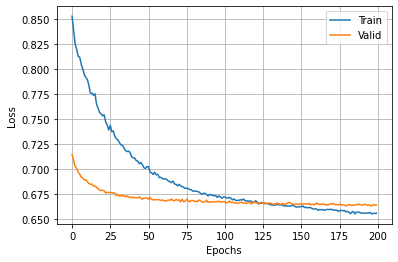

In [ ]:
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

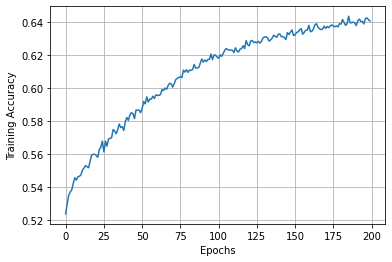

In [ ]:
plt.plot(train_accs)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.grid()

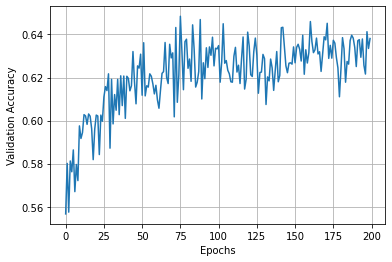

In [ ]:
plt.plot(valid_accs)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.grid()

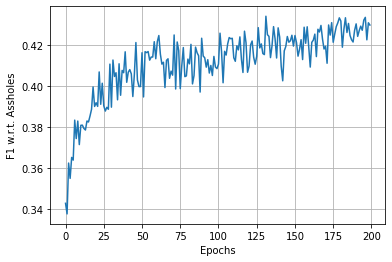

In [ ]:
plt.plot(valid_f1s_ass)
plt.xlabel("Epochs")
plt.ylabel("F1 w.r.t. Assholes")
plt.grid()

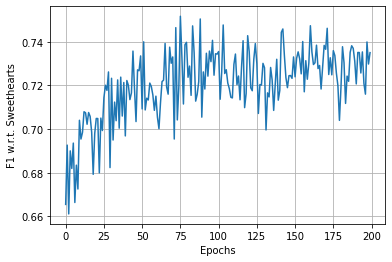

In [ ]:
plt.plot(valid_f1s_sweet)
plt.xlabel("Epochs")
plt.ylabel("F1 w.r.t. Sweethearts")
plt.grid()

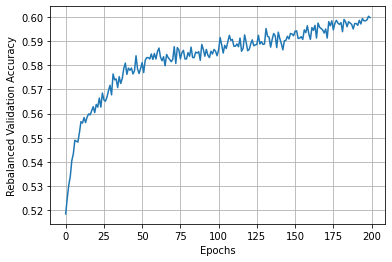

In [ ]:
plt.plot(valid_reb_accs)
plt.xlabel("Epochs")
plt.ylabel("Rebalanced Validation Accuracy")
plt.grid()

In [ ]:
X = next(iter(train_loader))[0].to(device)
with torch.no_grad():
    torch.jit.save(torch.jit.trace(model, (X), check_trace=False), '/content/drive/MyDrive/MastersProject/SavedModels/BertFullTitlesPlusFFNN1.pth')